In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd 'drive/MyDrive/GitHub/master-thesis'

/content/drive/MyDrive/GitHub/master-thesis


In [6]:
from clustering.utils import *

# Import Data

In [ ]:
%cd ..

In [330]:
df = pd.read_csv("data/clustering/220323_gmm_clustered_pca_2cluster.csv")

In [298]:
behaviour_cols = get_behaviour_cols()

# Silhouette Coefficient
Metric used to evaluate and compare cluster performance

The Silhouette Coefficient is defined for each sample and is composed of two scores:

a: The mean distance between a sample and all other points in the same class.

b: The mean distance between a sample and all other points in the next nearest cluster.

The Silhouette Coefficient s for a single sample is then given as:

s=(b-a)/max(a,b)


The Silhouette Coefficient for a set of samples is given as the mean of the Silhouette Coefficient for each sample.

In [334]:
from sklearn import metrics

df_sample = df.sample(20000) # used only for quick results, must be changed back to only df to get real score

X = df_sample[behaviour_cols].to_numpy()
labels = df_sample.group.to_numpy()
metrics.silhouette_score(X, labels, metric='euclidean')

0.04620716083135268

Scores:
- GMM 3 Cluster 0.00359
- GMM 7 Cluster: -0.0439
- GMM PCA 5 Cluster: -0.02312
- GMM PCA 2 Cluster: 0.046

# Filter and plot distribution of interesting columns

In [370]:
df_group_means = df[behaviour_cols + ['group']].copy()
df_group_means[behaviour_cols] = (df_group_means[behaviour_cols]-df_group_means[behaviour_cols].min())/(df_group_means[behaviour_cols].max()-df_group_means[behaviour_cols].min())
df_group_means.describe()

,Q1_2_covid_is_threat,Q2_1_easy_to_follow_advice,Q2_2_can_follow_advice_if_wanted,Q2_3_if_follow_advice_safe,Q2_4_if_follow_advice_others_safe,Q2_5_follow_advice_relationships_impared,Q2_6_follow_advice_life_degraded,Q3_1_aware_hand_hygiene,Q3_2_avoid_contact,Q3_3_ensure_frequent_cleaning,...,Q5_4_yourself_kept_distance,Q5_5_feel_urge_scold,Q6_2_advices_important,Q6_3_others_can_avoid_spreading,Q6_5_ownership_of_advice,Q6_6_clear_information_on_advice_reason,Q6_7_advice_limits_daily_activities,Q6_9_trust_political_strategy,Ny1_nr_times_wearing_masks_last_week,group
count,122829.000000,122829.000000,122829.000000,122829.000000,122829.000000,122829.000000,122829.000000,122829.000000,122829.000000,122829.000000,...,122829.000000,122829.000000,122829.000000,122829.000000,122829.000000,122829.000000,122829.000000,122829.000000,122829.000000,122829.000000
mean,0.632796,0.743667,0.831009,0.738295,0.839158,0.547727,0.411291,0.883781,0.753200,0.692122,...,0.806230,0.279378,0.812932,0.587110,0.769572,0.712227,0.536778,0.671766,0.482452,0.430916
std,0.295177,0.280585,0.269335,0.280695,0.267803,0.334862,0.320138,0.193061,0.277904,0.280316,...,0.220652,0.337071,0.247246,0.259411,0.262539,0.293448,0.324190,0.306492,0.361738,0.495206
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.666667,0.833333,0.500000,0.833333,0.333333,0.166667,0.833333,0.666667,0.500000,...,0.666667,0.000000,0.666667,0.500000,0.666667,0.500000,0.333333,0.500000,0.250000,0.000000
50%,0.666667,0.833333,1.000000,0.833333,1.000000,0.500000,0.500000,1.000000,0.833333,0.666667,...,0.833333,0.166667,0.833333,0.587110,0.833333,0.833333,0.500000,0.666667,0.482452,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,0.833333,0.666667,1.000000,1.000000,1.000000,...,1.000000,0.500000,1.000000,0.833333,1.000000,1.000000,0.833333,1.000000,0.750000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [336]:
pc_col =  []
for i in np.arange(11):
  col_name = 'PC_' + str(i)
  pc_col.append(col_name)
df_group_means = df[pc_col + ['group']].copy()

In [371]:
df_group_means = df_group_means.groupby('group').mean().reset_index().transpose()
df_group_means.drop('group', inplace=True)
df_group_means.reset_index(inplace=True)
df_group_means['std'] = df_group_means.std(axis=1)
df_group_means = df_group_means.sort_values(by='std', ascending=False)
df_group_means.iloc[:10]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



,index,0,1,std
15,Q5_5_feel_urge_scold,0.490925,0.000000,0.347137
13,Q3_7_minimize_activities_w_contact,0.739049,0.643674,0.067440
12,Q3_6_avoid_crowds,0.785631,0.694427,0.064491
9,Q3_3_ensure_frequent_cleaning,0.730021,0.642072,0.062190
11,Q3_5_keep_distance,0.808597,0.721475,0.061605
8,Q3_2_avoid_contact,0.789803,0.704861,0.060063
17,Q6_3_others_can_avoid_spreading,0.554846,0.629718,0.052942
2,Q2_2_can_follow_advice_if_wanted,0.799034,0.873235,0.052468
0,Q1_2_covid_is_threat,0.660799,0.595815,0.045950
10,Q3_4_avoid_risk_groups,0.863515,0.802330,0.043264


In [372]:
top_3_cols = df_group_means['index'].iloc[:3].tolist()
top_3_cols

['Q5_5_feel_urge_scold',
 'Q3_7_minimize_activities_w_contact',
 'Q3_6_avoid_crowds']

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1106: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



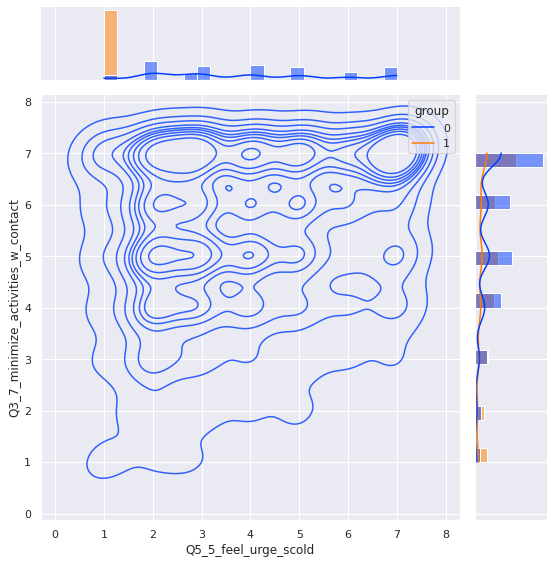

In [373]:
df_sample = df.sample(10000)

g = sns.JointGrid(data=df_sample, x=top_3_cols[0], y=top_3_cols[1], hue="group", palette='bright', height=8) # hue_order=[1, 2, 0],
g.plot_joint(sns.kdeplot, alpha=0.8) #or scatterplot
g.plot_marginals(sns.histplot, kde=True) #or kdeplot

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



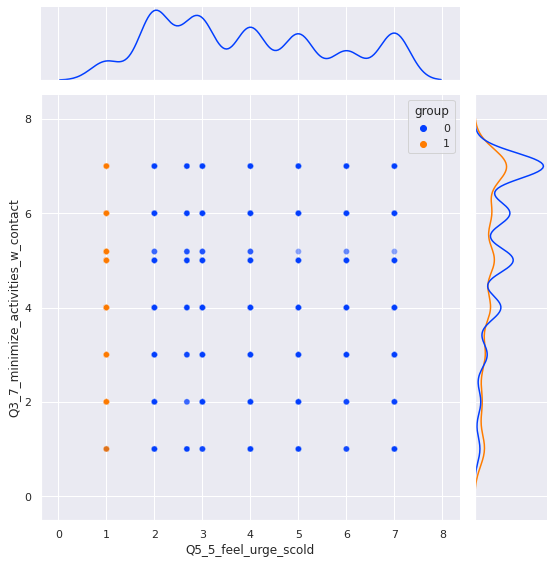

In [375]:
g = sns.JointGrid(data=df_sample, x=top_3_cols[0], y=top_3_cols[1], hue="group", palette='bright', height=8) # hue_order=[1, 2, 0],
g.plot_joint(sns.scatterplot, alpha=0.25) #or scatterplot
g.plot_marginals(sns.kdeplot) #or kdeplot

In [374]:
df_sample.group = df_sample.group.astype(str)
fig = px.scatter_3d(df_sample, x=top_3_cols[0], y=top_3_cols[1], z=top_3_cols[2], color='group', opacity=0.5)
fig.show()

In [365]:
"""for blickwinkel in np.arange(0, 270, 30):

  fig = plt.figure(figsize=(8, 8))

  ax = plt.axes(projection='3d')
  color_list = ['red', 'green', 'blue', 'yellow', 'grey']
  i=0
  x_name = top_3_cols[0]#'PC_0'
  y_name = top_3_cols[1]#'PC_3'
  z_name = top_3_cols[2]#'PC_2'
  for group in df_sample['group'].unique().tolist():
    x = df_sample[df_sample['group']==group][x_name]
    y = df_sample[df_sample['group']==group][y_name]
    z = df_sample[df_sample['group']==group][z_name]
    ax.scatter3D(x, y, z, alpha=0.1, color=color_list[i], label=str(group))
    ax.set_title('Blickwinkel: ' + str(blickwinkel) + ' Grad')
    i = i+1
  ax.legend()
  ax.set_xlabel(x_name)
  ax.set_ylabel(y_name)
  ax.set_zlabel(z_name)

  ax.azim = blickwinkel #90 #135 #180 #225 #270
  ax.elev = 40"""

"for blickwinkel in np.arange(0, 270, 30):\n\n  fig = plt.figure(figsize=(8, 8))\n\n  ax = plt.axes(projection='3d')\n  color_list = ['red', 'green', 'blue', 'yellow', 'grey']\n  i=0\n  x_name = top_3_cols[0]#'PC_0'\n  y_name = top_3_cols[1]#'PC_3'\n  z_name = top_3_cols[2]#'PC_2'\n  for group in df_sample['group'].unique().tolist():\n    x = df_sample[df_sample['group']==group][x_name]\n    y = df_sample[df_sample['group']==group][y_name]\n    z = df_sample[df_sample['group']==group][z_name]\n    ax.scatter3D(x, y, z, alpha=0.1, color=color_list[i], label=str(group))\n    ax.set_title('Blickwinkel: ' + str(blickwinkel) + ' Grad')\n    i = i+1\n  ax.legend()\n  ax.set_xlabel(x_name)\n  ax.set_ylabel(y_name)\n  ax.set_zlabel(z_name)\n\n  ax.azim = blickwinkel #90 #135 #180 #225 #270\n  ax.elev = 40"

# Answers Distributions

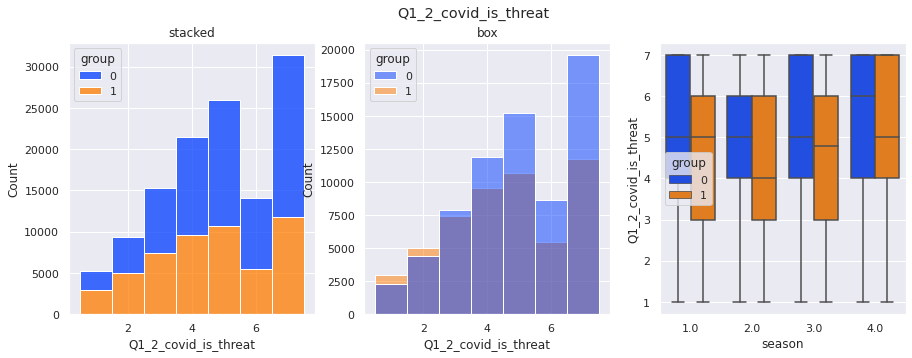

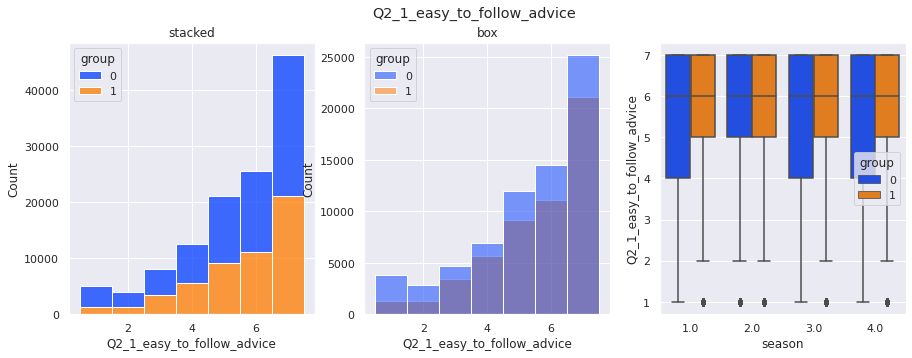

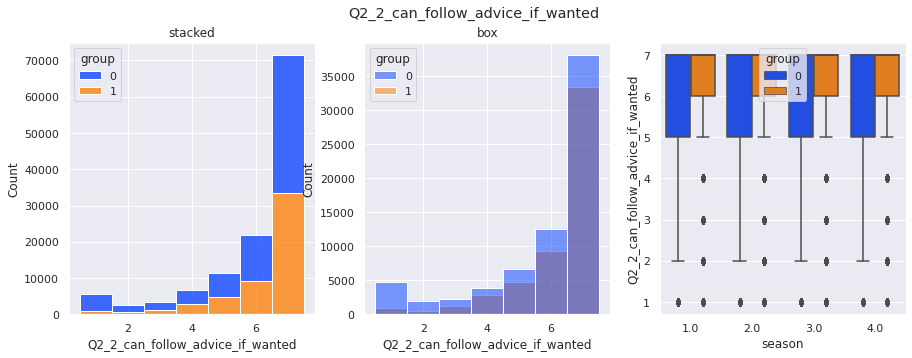

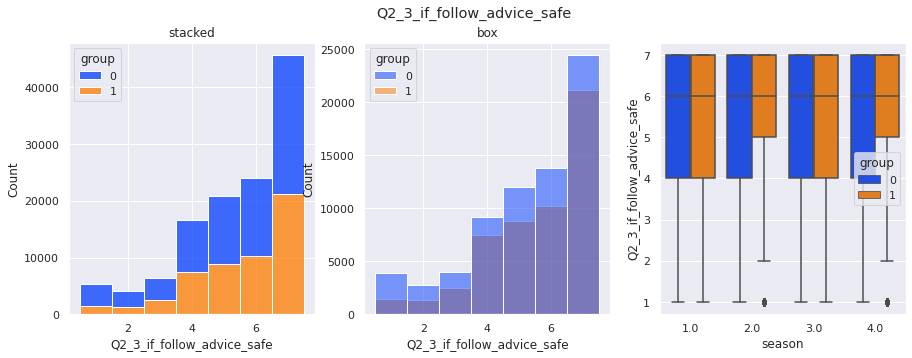

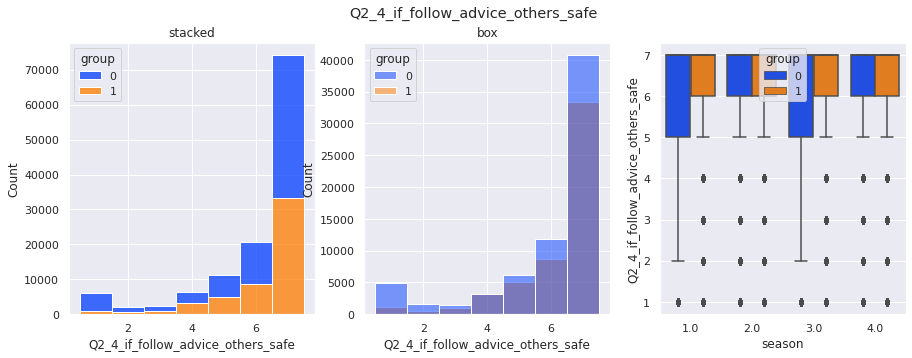

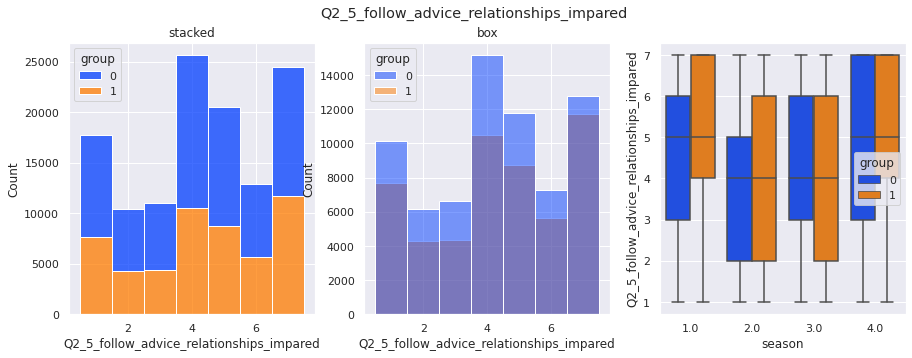

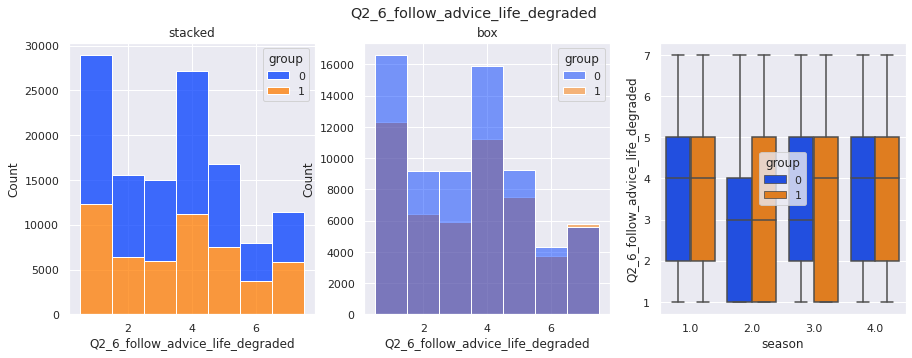

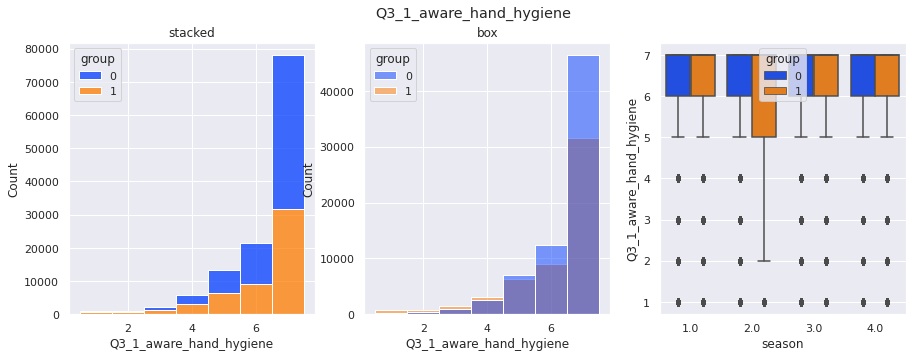

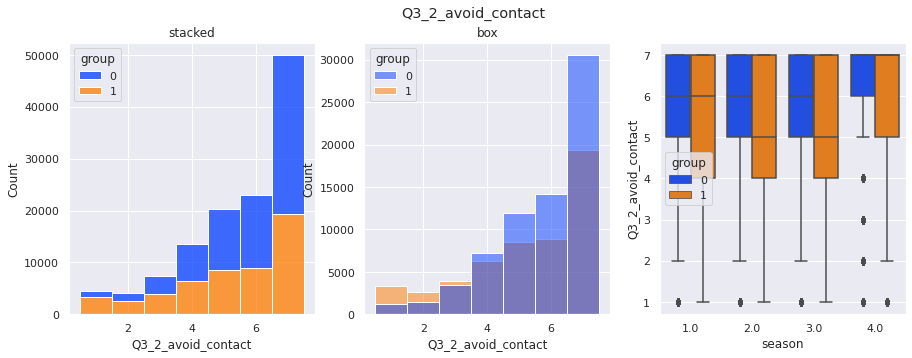

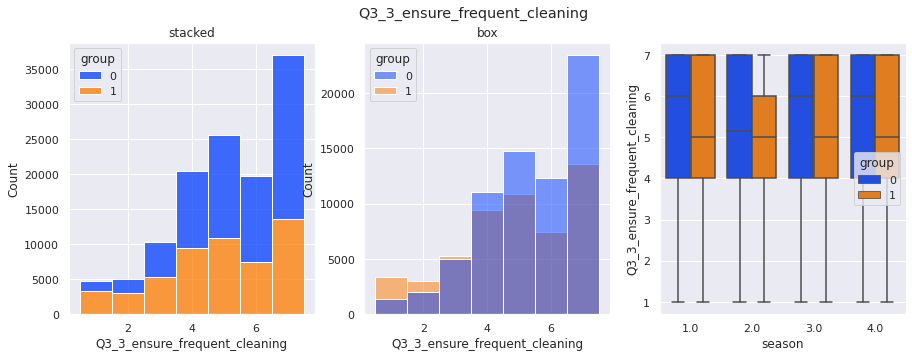

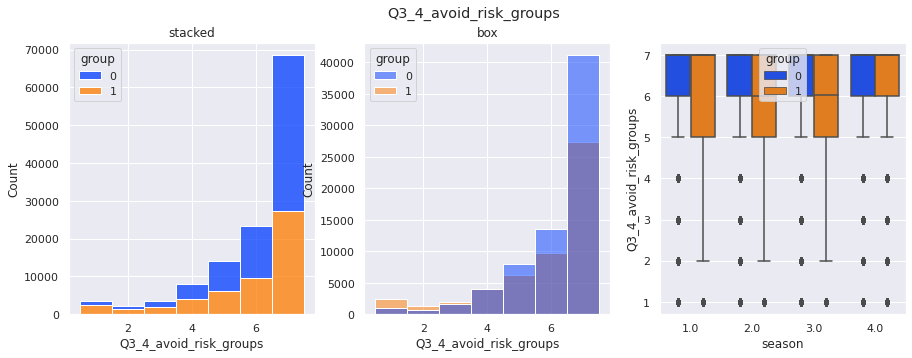

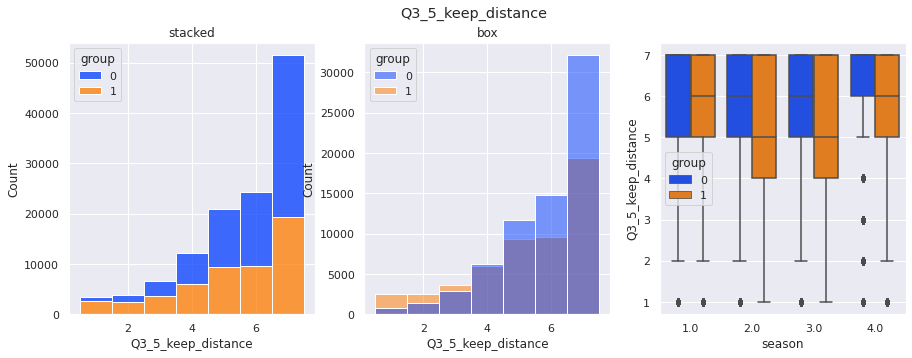

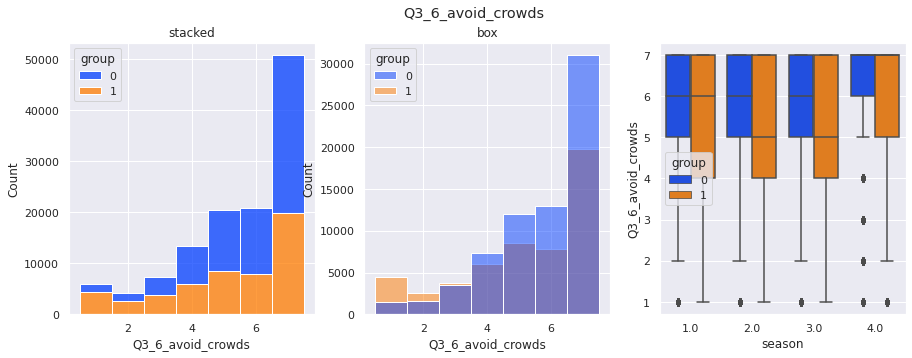

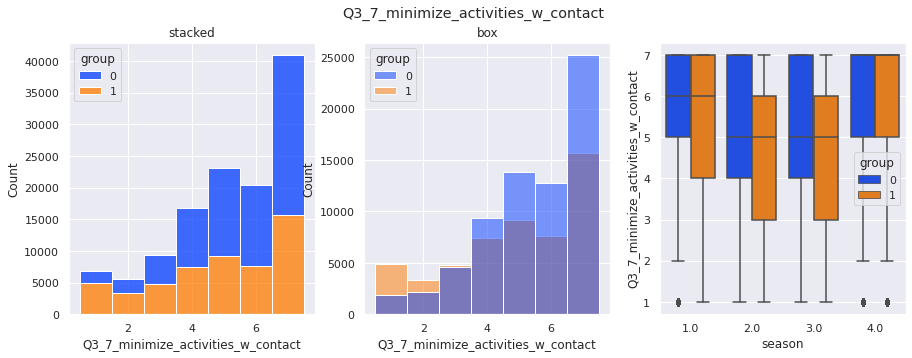

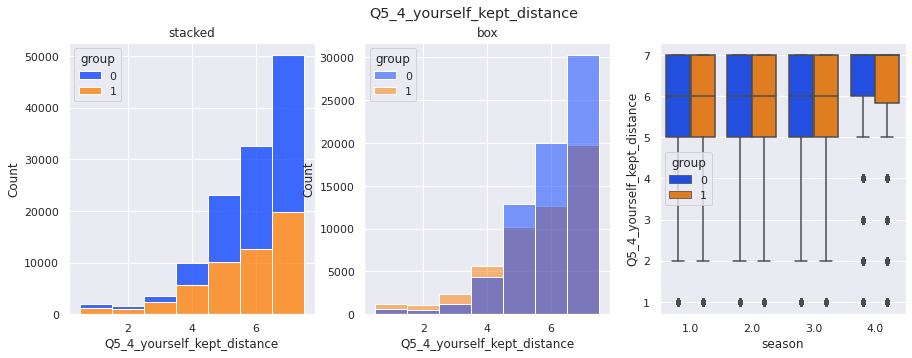

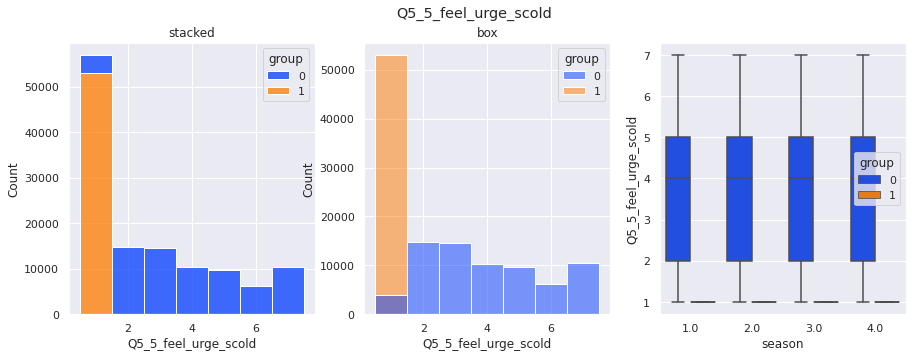

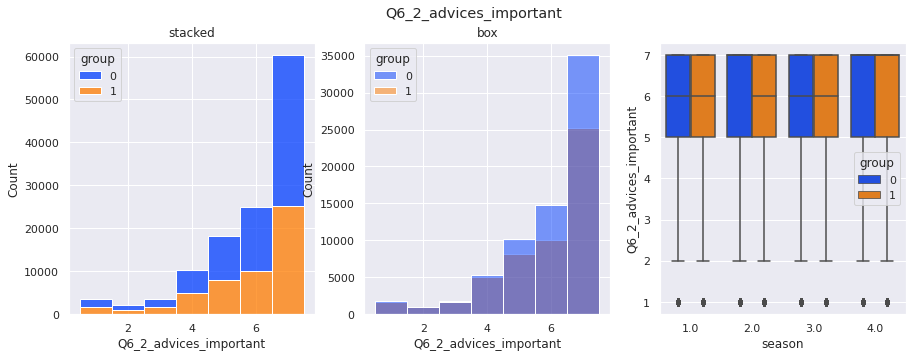

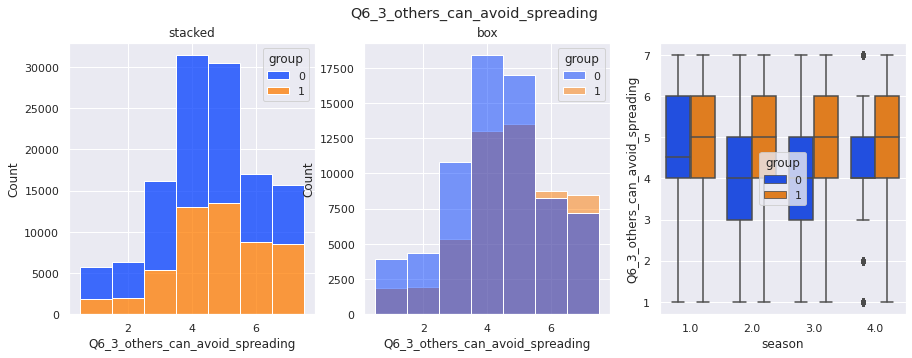

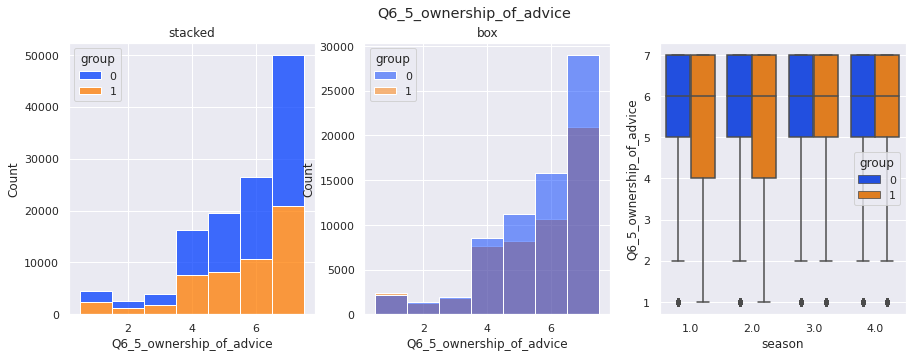

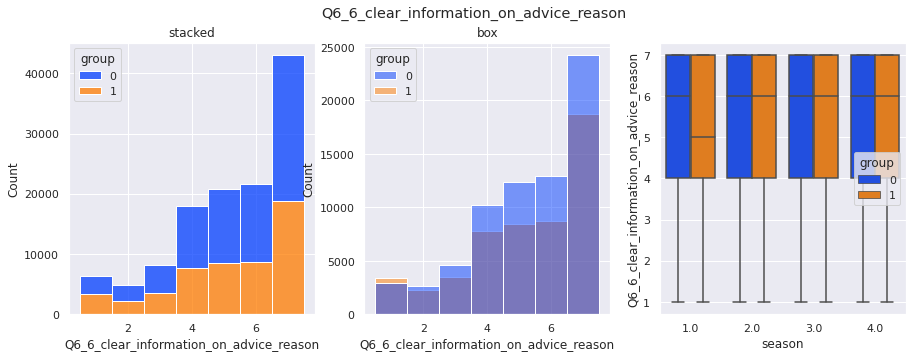

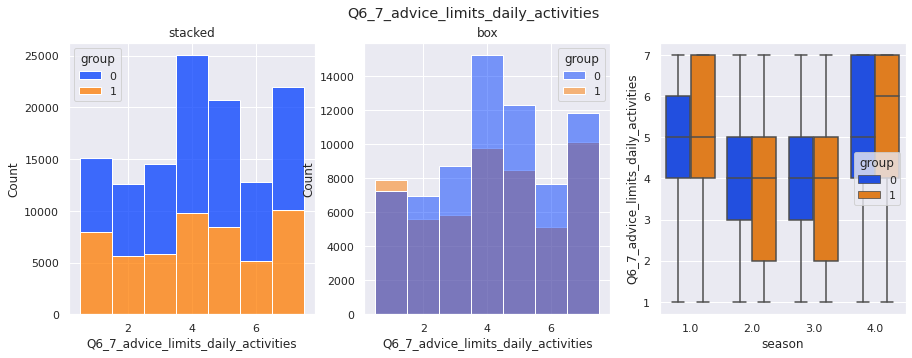

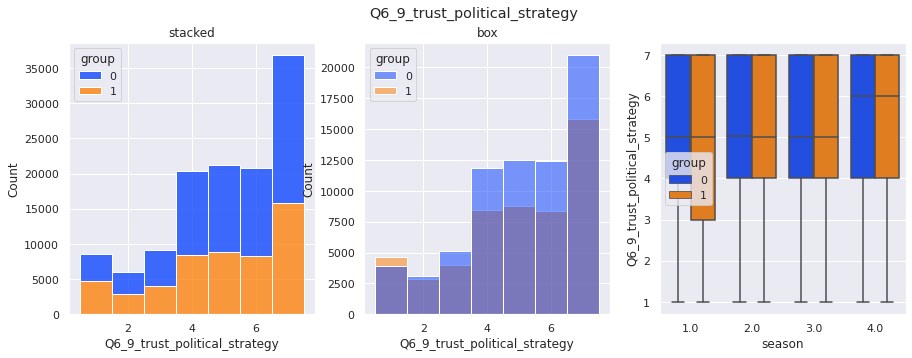

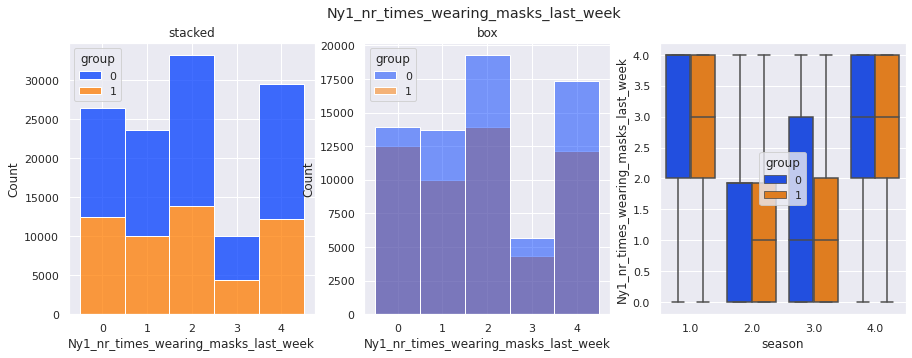

In [342]:
for col in behaviour_cols:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
    fig.suptitle(col)
    sns.histplot(data=df.round(), x=col, hue="group", discrete=True, multiple="stack",ax=axes[0], palette='bright')
    axes[0].set_title('stacked')
    sns.histplot(data=df.round(), x=col, hue="group", discrete=True,ax=axes[1], palette='bright')
    axes[1].set_title('transparent')
    sns.boxplot(x="season", y=col, hue="group",data=df, ax=axes[2], palette='bright')
    axes[1].set_title('box')
    plt.show()

# Group distance # change so that it takes multiple groups into account

In [343]:
df_dict = []
for i, day in  df[behaviour_cols + ['date', 'group']].groupby(['date']):
     groups_dist = np.abs(day[day['group']== 0].mean() - day[day['group']== 1].mean())
     dist = np.linalg.norm(groups_dist.values, ord=1)
     df_dict.append({'time':i, 'distance': dist})
dist_df = pd.DataFrame(df_dict)
dist_df['dist_smooth'] = dist_df.distance.rolling(7).mean()
fig = px.line(dist_df,x='time', y=['distance', 'dist_smooth'])
fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



# Plot Group Sizes

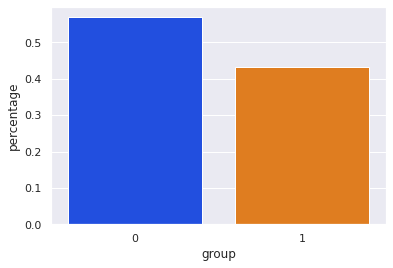

In [344]:
df_group_size = df[['group', 'gender']].groupby('group').count().reset_index()
df_group_size['gender'] = df_group_size['gender'] / df_group_size['gender'].sum()
df_group_size.rename(columns={'gender':'percentage'}, inplace=True)
sns.barplot(data=df_group_size, x='group', y='percentage', palette='bright')

# Daily distribution

In [345]:
groups_percentage = df.groupby(['date','group'],as_index=False)['gender'].count()
def normalize(row):
  sum = groups_percentage[groups_percentage['date']==row['date']]['gender'].sum()
  return row['gender']/sum

groups_percentage['percentage'] = groups_percentage.apply(lambda x: normalize(x), axis=1)
groups_percentage['date'] = pd.to_datetime(groups_percentage['date'])
groups_percentage.drop(columns='gender',inplace=True)
#fig = px.line(groups_percentage, x="date", y="percentage", color='group', title='Group daily distribution')
#fig.show()

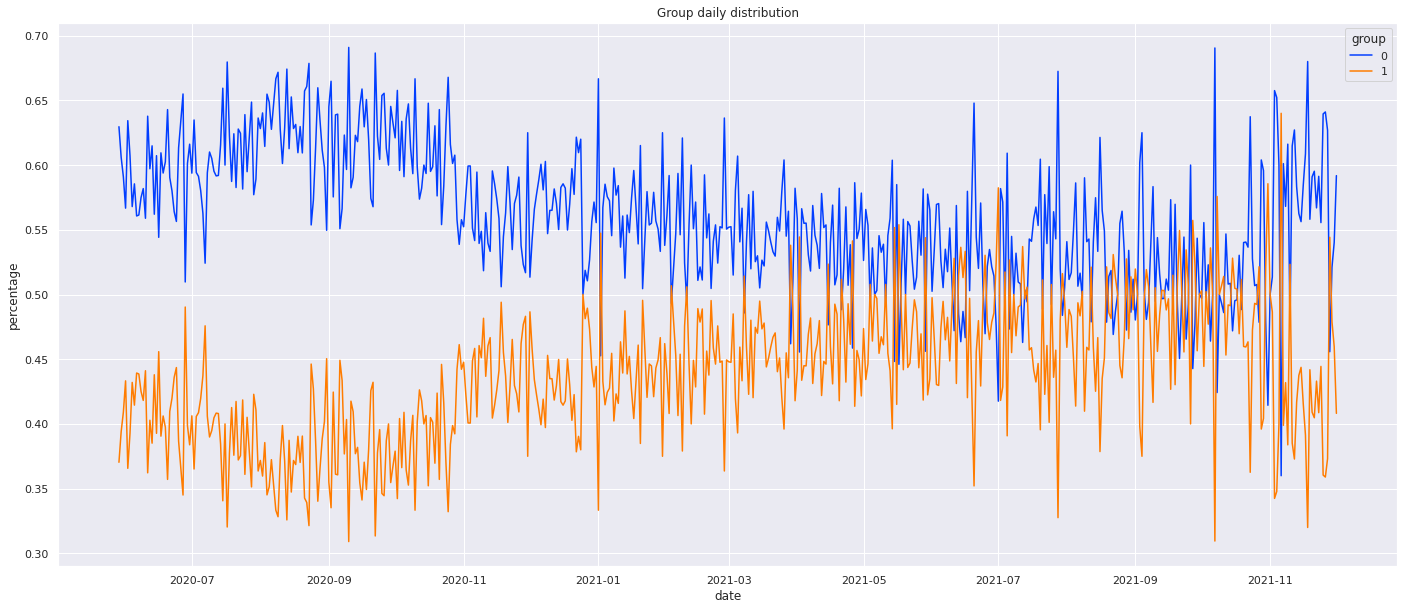

In [346]:
fig, ax = plt.subplots(figsize=(24, 10))
sns.lineplot(data=groups_percentage, x='date', y='percentage', hue='group', palette="bright", ax=ax)
plt.title('Group daily distribution')
plt.show()

# Daily Average Group Answer

In [347]:
df_daily_average = df.groupby(['date','group']).mean().reset_index()
df_daily_average.date = pd.to_datetime(df_daily_average.date)
for col in df_daily_average.columns:
    sns.lineplot(data=df_daily_average, x='date', y=col, hue='group', palette="bright")
    plt.title(col)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [226]:
df_daily_average = df.groupby(['date','group']).mean().reset_index()
df_daily_average_0 = df_daily_average[df_daily_average.group == 0]
df_daily_average_1 = df_daily_average[df_daily_average.group == 1]
for col in df_daily_average_0.columns:
    plt.plot(df_daily_average_0.date,df_daily_average_0[col], label='0')
    plt.plot(df_daily_average_1.date,df_daily_average_1[col], label='1')
    plt.legend()
    plt.title(col)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Observations

In [ ]:
observations = pd.read_csv('data/observations_30012022.csv',sep=';', decimal=',', encoding='utf-8')
sliced_observations = observations.iloc[92:643]
fig = px.line(sliced_observations, x="Date", y=sliced_observations.columns[2:])
fig.show()